<h1 style="color: #2b74af; font-size: 40px; background: lightBlue; padding: 15px; border-radius: 15px; box-shadow: 4px 4px 4px dark">Librerías</h1>

In [1]:
import numpy as np
import random

<h1 style="color: #2b74af; font-size: 40px; background: lightBlue; padding: 15px; border-radius: 15px; box-shadow: 4px 4px 4px dark">Funciones útiles</h1>

In [2]:
def lastProm(array, amount):
    suma = 0
    last = array.__len__()
    if last == 0:
        return 0
    if last < amount:
        for x in array:
            suma += x
        return suma/(last)
    for x in range(amount):
        suma += array[last-(x+1)]
    return suma/amount

<h1 style="color: #2b74af; font-size: 40px; background: lightBlue; padding: 15px; border-radius: 15px; box-shadow: 4px 4px 4px dark">Clase</h1>

<div class="alert alert-block alert-info"><h1>La clase toma como parametros posibles:</h1>
    
- Estados en los que existirá el agente
- Tamaño de discretización (de cada estado por separado)
- Hiperparametros epsilon, alpha, gamma.
- "epsilonDecay" y "alphaDecay" son los epsilon y alpha finales. (Una vez que el agente logra la recompenza objetivo)
- La recompenza esperada
- "continues" es una variable booleana para indicar si el ambiente del agente es de estados continuos o discretos.
- Los valores minimos y máximos de cada estado del agente.
- "auto" es para determinar si el agente debe setear sus hiperparametros (alpha, epsilon, adecay y edecay) de manera automatica (actualmente los selecciona al azar).

Además, la clase tiene un arreglo "*memory*" en la que puede almacenar el puntaje obtenido con una configuración automática de hiperparametros. (Mi idea es posteriormente usar esto para empezar a aplicar metodos de optimización de hiperparametros).

En la inicialización o construcción de la clase, el agente crea una matriz "policy" con todos valores cero.
</div>

In [3]:
class Agent:

    def __init__(self,state,posibleActions,sampleSize = [],epsilon = 0,alpha = 0,gamma = 0,epsilonDecay = 0,
        alphaDecay = 0, expectedReturn = 0, continues = False, minimum = [], maximum = [], auto = False):
        self.state = state
        self.actions = posibleActions
        self.sampleSize = sampleSize
        self.epsilon = 1 - epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.epsilonDecay = epsilonDecay
        self.alphaDecay = alphaDecay
        self.policy = self.initializePolicy(state,posibleActions,sampleSize)
        self.continues = continues
        self.minimum = minimum
        self.maximum = maximum
        self.record = []
        self.expectedReturn = expectedReturn
        self.alphaOriginal = alpha
        self.epsilonOriginal = epsilon
        if (auto):
            self.memory = []
            self.alpha = random.random()*1
            self.alphaOriginal = self.alpha
            self.epsilon = random.random()*1
            self.epsilonOriginal = self.epsilon
            self.epsilonDecay = random.random()*1
            self.alphaDecay = random.random()*1

<div class="alert alert-block alert-info"> 
    <h1>Función "decide"</h1>
    
   La clase tiene un metodo en el que tomará decisiones dado el estado en el que se encuentre al tomar la decisión (no toma parametros). Para la exploración y explotación se utiliza una función "*softmax*": $$P(a)= \frac{e^{\alpha Q(a|s)}} {\sum_{i=0}^{i=j} e^{\alpha Q(i|s)}} \iff j = posibeActions$$
   
   Esta función lo que hace es tomar un vector y procesarlo de manera que su modulo sea igual a uno. Luego según que tan grande sea cada parametro del vector, le damos una probabilidad a cada acción de que suceda. El parametro alpha se usa para poder variar el nivel de exploración y/o explotación. Notese que cuando alpha es igual a cero, todos los valores del vector tendrán igual magnitud, es decir, tendremos exploración pura. Por el contrario, a medida que alpha se hace mas grande, conseguimos tender más a la explotación.
   
   Por último, en el algoritmo se le resta a Q(a|s) el max[Q(s)] para normalizar la función y evitar problemas de overflow.
   </div>

In [4]:
    def decide(self):
        inputs = self.policy[tuple(self.state)]
        probability0 = np.exp((inputs-np.amax(inputs))*self.epsilon) / float(sum(np.exp((inputs-np.amax(inputs))*self.epsilon)))
        probability1 = np.exp((inputs-np.amax(inputs))*self.epsilon) / float(sum(np.exp((inputs-np.amax(inputs))*self.epsilon)))
        probability1.sort()
        chance = 0
        posibility = random.random()
        for action in probability1:
            chance += action
            if chance > posibility:
                return np.where(probability0 == action)[0][0]

<div class="alert alert-block alert-info"> 
    <h1>Función "update"</h1>
    
   Llamada cada vez que se termina un episodio, en la función update, el agente guarda en su memoria ("record") la recompenza obtenida en el episodio (pasada como parametro para la función), y actualiza los valores de alpha y epsilon según que tan cerca este de la recompenza esperada final. La actualización es lineal.
   </div>

In [5]:
    def update(self,reward):
        if self.record.__len__() < 1:
            self.rewardOffset = abs(reward - self.expectedReturn)
        self.record.append(reward)
        newAlpha = self.alphaOriginal * self.alphaDecay * (1/pow(self.alphaDecay, abs(lastProm(self.record, 200) - self.expectedReturn) / self.rewardOffset))
        newEpsilon = self.epsilonOriginal * self.epsilonDecay * (1/pow(self.epsilonDecay, abs(lastProm(self.record, 200) - self.expectedReturn) / self.rewardOffset))
        self.alpha = newAlpha
        self.epsilon = newEpsilon


<div class="alert alert-block alert-info"> 
    <h1>Función "optimize"</h1>
    
   Por el momento la función "optimize" simplemente selecciona al azar valores para los hiperparametros principales, y guarda en "memory" una recompenza promedio lograda con una configuración de hiperparametros especifica. Esta función, la imagino sin mayores cambios cuando se aplique optimización Bayesiana, pero seleccionando los nuevos valores según el grado de incertidumbre que tuvieramos en el modelo construido (Todavía el algoritmo no hace ningun modelo, pero es como imagino debería seguir el funcionamiento de la optimización).
   </div>

In [6]:
    def optimize(self, reward):
        self.memory.append([reward, self.alphaOriginal, self.epsilonOriginal, self.alphaDecay, self.epsilonDecay])
        self.alpha = random.random()
        self.alphaOriginal = self.alpha
        self.epsilon = random.random()
        self.epsilonOriginal = self.epsilon
        self.alphaDecay = random.random()
        self.epsilonDecay = random.random()
        self.policy = self.initializePolicy(self.state,self.actions,self.sampleSize)
        self.record = []

<div class="alert alert-block alert-info"> 
    <h1>Función "learn"</h1>
    
   En esta función se aplica Q-learning, actualizando los valores de la matriz según dicho algoritmo:
   $$Q(s_{t},a_{t}) = (1- \alpha) \cdot Q(s_{t},a_{t}) + \alpha \cdot [r_{t} + \gamma \cdot max_{Q(s_{t},a)}] $$
   
   Mi intención es aplicar "n-step" bootstraping para que pueda ser una parametro de configuración mas. Y también poder aplicar conceptos de redes neuronales para que el algoritmo también pueda usar el modelo de "*Deep Q Learning*".
   </div>

In [7]:
    def learn(self, newState, actionTaken, reward):
        if self.continues:
            newStatef = self.discretize(newState)
        fullState = self.state
        fullState.append(actionTaken)
        old_value = self.policy[tuple(fullState)]
        new_value = (1 - self.alpha) * old_value + self.alpha * (reward + self.gamma*(max(self.policy[tuple(newStatef)])))
        self.policy[tuple(fullState)] = new_value
        self.setState(newState)

<div class="alert alert-block alert-info"> 
    <h1>Función "initializePolicy"</h1>
    
   Función en la que inicializo la politica del agente dado un array de estados posibles, un array de acciones posibles y un tamaño de muestreo en los que son divididos los estados. Lo mas interesante de la función, y tambien del algoritmo en su conjunto, es que toma arrays de multiples dimensiones, por lo que el agente se puede adaptar con relativa facilidad a ambientes en los que tenga que atender diversas cantidades de estados (Siendo limite la capacidad de procesamiento disponible).
   </div>

In [8]:
    def initializePolicy(self,states,actions,sampleSize):
        array = []
        for state in range(states.__len__()):
            array.append(sampleSize[state])
        array.append(actions.__len__())
        policy = np.zeros(array)
        return policy

<div class="alert alert-block alert-info"> 
    <h1>Función "discretize"</h1>
    
   Para poder adaptarse a ambientes continuos, el agente tiene una función con la que discretize el estado dado por el entorno, y lo mapea según el muestreo, y los valores máximos y mínimos, especificados en la construcción del agente.
   </div>

In [9]:
    def discretize(self, states):
        j = -1
        discreteState = []
        for state in states:
            j += 1
            increment = (abs(self.minimum[j])+self.maximum[j])/self.sampleSize[j]
            for i in range(0, self.sampleSize[j]):
                if state < increment*(i+1) + self.minimum[j]:
                    discreteState.append(i)
                    break
        return discreteState

<div class="alert alert-block alert-info"> 
    <h1>Función "setState"</h1>
    
   Una función para poder actualizar el estado en el que e encuentra el agente.
   
   Me pareció mas interesante que el agente puede moverse de estados y decidir posteriormente según el estado en el que se encuentre, que pasar el estado actual a la función "decide".
   </div>

In [10]:
    def setState(self,state):
        if self.continues :
            self.state = self.discretize(state)
        if not(self.continues):
            self.state = state

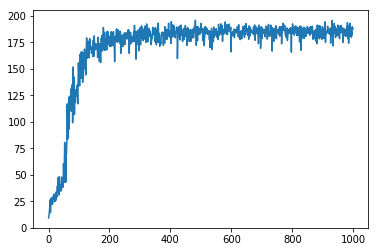

In [16]:
import learning
import gym
import matplotlib.pyplot as plt
import numpy as np
import random

env = gym.make('CartPole-v0')

states = [0,0,0,0]
actions = [0,0]

maximum = [2.5, 4, 0.8, 4]
minimum = [-2.5, -4, -0.8,-4]

episodes = 1000
Intents = []

for metaEpisode in range(10):
    
    rewards = []
    
    cart = learning.Agent(
        state = states,
        sampleSize = [10,1,30,30],
        posibleActions = actions,
        epsilon = 0.149862682,
        alpha = 0.818792154792417,
        gamma = 1,
        epsilonDecay = 1.18220248060764,
        alphaDecay = 0.268458061557817,
        expectedReturn = 200,
        continues = True,
        maximum = maximum,
        minimum = minimum
        )

    for episode in range(episodes):

        observation = env.reset()
        episodeReward = 0
        cart.setState(observation)

        for step in range(200):
                
            action = cart.decide()
            
            observation, reward, done, info = env.step(action)

            episodeReward += reward

            cart.learn(observation,action,reward)

            if done:
                rewards.append(episodeReward)
                cart.update(episodeReward)
                print ("Intent: " + str(metaEpisode) + " - Episode: " + str(episode) + " (alpha = "+ str(round(cart.alpha,2)) +" || epsilon = " + str(round(cart.epsilon,2)) + ")  -> Score: " + str(round(lastProm(cart.record,100),2)), end="\r")
                episodeReward = 0
                break

    Intents.append(rewards)

plt.plot(np.mean(Intents, axis=0))
plt.show()